## 1.**Import Module n Data**

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from pickle import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# filePath = "/work/DA-course-UEL/04. Final Project/Dataset/datanosplit.csv"
filePath = "Dataset/datanosplit.csv"

In [3]:
df = pd.read_csv(filePath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370789 entries, 0 to 370788
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      370789 non-null  int64  
 1   Gender                  370789 non-null  int64  
 2   Age                     370789 non-null  float64
 3   Driving_License         370789 non-null  int64  
 4   Region_Code             370789 non-null  int64  
 5   Previously_Insured      370789 non-null  int64  
 6   Annual_Premium          370789 non-null  float64
 7   Policy_Sales_Channel    370789 non-null  int64  
 8   Vintage                 370789 non-null  float64
 9   Response                370789 non-null  int64  
 10  Vehicle_Age_lt_1_Year   370789 non-null  int64  
 11  Vehicle_Age_gt_2_Years  370789 non-null  int64  
 12  Vehicle_Damage_Yes      370789 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 36.8 MB


In [4]:
input_features = ['Age', 'Previously_Insured', 'Policy_Sales_Channel',
       'Vehicle_Age_lt_1_Year', 'Vehicle_Age_gt_2_Years', 'Vehicle_Damage_Yes', 'Region_Code', 'Annual_Premium']
X = df[input_features]
y = df['Response']

# **1. Analysis**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
                                                        X, y, 
                                                        stratify=y,
                                                        test_size=0.2, 
                                                        random_state=42
                                                    )

In [6]:
X_train.shape, X_test.shape

((296631, 8), (74158, 8))

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 260507, 1: 36124})
Resampled dataset shape Counter({0: 260507, 1: 260507})


# **2. Building Classification Models**

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix

## *2.1. KNN*

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# {'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'uniform'}
knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform') # Define classifier
knn.fit(X_res, y_res) # Train model

dump(knn, open('knn.pkl', 'wb'))

In [21]:
from sklearn.metrics import roc_curve, accuracy_score, f1_score, classification_report, confusion_matrix

def evaluateModel(modelFile, X_test, y_test):
    model = load(open(modelFile, 'rb'))
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Model performance for Test set')
    print('- Accuracy: %s' % accuracy)
    print('- F1 score: %s' % f1)
    print('- Classification Report\n', classification_report(y_test, y_test_pred))
    #visualize confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
    plt.title(all_sample_title, size = 15)
    #visualize ROC curve - AUC for label 1
    y_test_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## *2.2. Decision Tree*

In [13]:
from sklearn.tree import DecisionTreeClassifier

#  {'criterion': 'entropy', 'max_depth': 6}
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dt.fit(X_res, y_res)

dump(dt, open('decision_tree.pkl', 'wb'))

Model performance for Test set
- Accuracy: 0.7094986380430972
- F1 score: 0.7594136231283587
- Classification Report
               precision    recall  f1-score   support

           0       0.98      0.68      0.81     65127
           1       0.28      0.90      0.43      9031

    accuracy                           0.71     74158
   macro avg       0.63      0.79      0.62     74158
weighted avg       0.90      0.71      0.76     74158



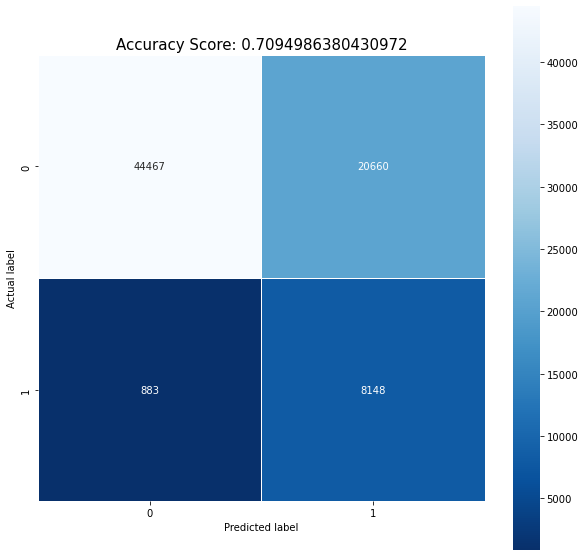

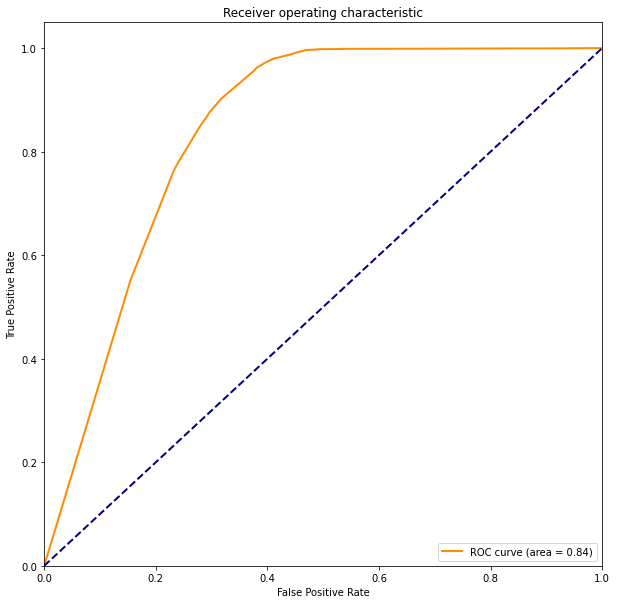

In [22]:
evaluateModel('decision_tree.pkl', X_test, y_test)

## *2.3. Logistic Regresstion*

In [25]:
from sklearn.linear_model import LogisticRegression

# {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")  # Define classifier
lr.fit(X_res, y_res)  # Train model

dump(lr, open("logistic_regression.pkl", "wb"))


Model performance for Test set
- Accuracy: 0.6374902235766876
- F1 score: 0.6990252899158317
- Classification Report
               precision    recall  f1-score   support

           0       0.99      0.59      0.74     65127
           1       0.25      0.97      0.40      9031

    accuracy                           0.64     74158
   macro avg       0.62      0.78      0.57     74158
weighted avg       0.90      0.64      0.70     74158



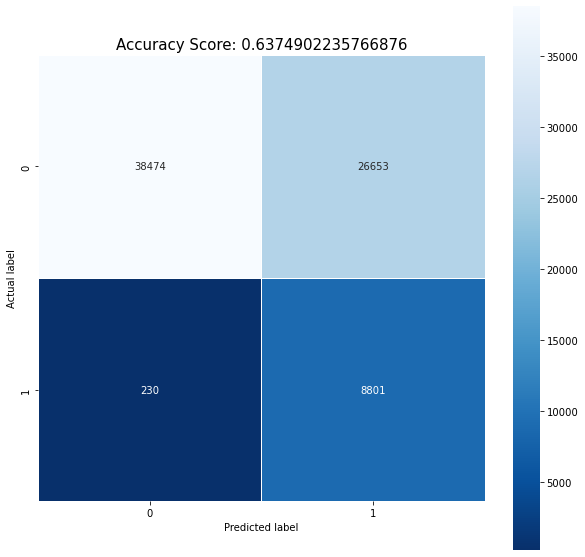

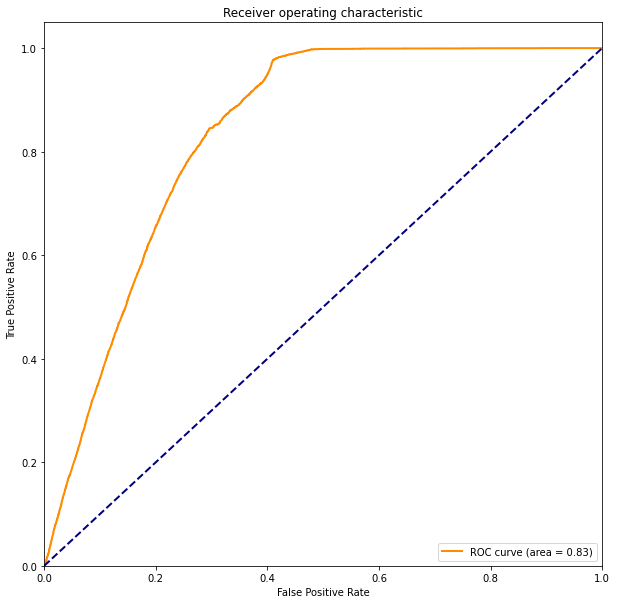

In [26]:
evaluateModel('logistic_regression.pkl', X_test, y_test)

# **3. Stacking Model**

## 3.1. Stacking: (KNN-LR)+LR

In [27]:
from sklearn.ensemble import StackingClassifier

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform')
lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")

estimator_list = [
    ('knn',knn),
    ('lr', lr)]

# Build stack model
stack_knn_lr_metaLR = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_knn_lr_metaLR.fit(X_res, y_res)

dump(stack_knn_lr_metaLR, open('stacking_knn_lr_metaLR.pkl', 'wb'))

In [ ]:
evaluateModel('stacking_knn_lr_metaLR.pkl', X_test, y_test)

## 3.2. Stacking: (KNN-LR)+XGB

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform')
lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")

estimator_list = [
    ('knn',knn),
    ('lr', lr)]

# Build stack model
stack_knn_lr_metaXGB = StackingClassifier(
    estimators=estimator_list, final_estimator=XGBClassifier()
)

# Train stacked model
stack_knn_lr_metaXGB.fit(X_res, y_res)

dump(stack_knn_lr_metaXGB, open('stack_knn_lr_metaXGB.pkl', 'wb'))

In [ ]:
evaluateModel('stack_knn_lr_metaXGB.pkl', X_test, y_test)

## 3.3. Stacking: (KNN-DT)+XGB

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)

estimator_list = [
    ('knn',knn),
    ('dt',dt)]

# Build stack model
stack_knn_dt_metaXGB = StackingClassifier(
    estimators=estimator_list, final_estimator=XGBClassifier()
)

# Train stacked model
stack_knn_dt_metaXGB.fit(X_res, y_res)

dump(stack_knn_dt_metaXGB, open('stack_knn_dt_metaXGB.pkl', 'wb'))


In [ ]:
evaluateModel('stack_knn_dt_metaXGB.pkl', X_test, y_test)

## 3.4. Stacking: (KNN-DT)+LR

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform')
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)

estimator_list = [
    ('knn',knn),
    ('dt',dt)]

# Build stack model
stack_knn_dt_metaLR = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_knn_dt_metaLR.fit(X_res, y_res)

dump(stack_knn_dt_metaLR, open('stack_knn_dt_metaLR.pkl', 'wb'))


## 3.5. Stacking: (DT-LR)+LR

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)

estimator_list = [
    ('lr',lr),
    ('dt',dt)]

# Build stack model
stack_dt_lr_metaLR = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# Train stacked model
stack_dt_lr_metaLR.fit(X_res, y_res)

dump(stack_dt_lr_metaLR, open('stack_dt_lr_metaLR.pkl', 'wb'))

In [ ]:
evaluateModel('stack_dt_lr_metaLR.pkl', X_test, y_test)

## 3.6. Stacking: (DT-LR)+XGB

In [ ]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)

estimator_list = [
    ('lr',lr),
    ('dt',dt)]

# Build stack model
stack_dt_lr_metaXGB = StackingClassifier(
    estimators=estimator_list, final_estimator=XGBClassifier()
)

# Train stacked model
stack_dt_lr_metaXGB.fit(X_res, y_res)

dump(stack_dt_lr_metaXGB, open('stack_dt_lr_metaXGB.pkl', 'wb'))


In [ ]:
evaluateModel('stack_dt_lr_metaXGB.pkl', X_test, y_test)

## 3.8. Stacking: (DT-LR-KNN-CatBoost-XGBoost-RF)+ MetaModel

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

lr = LogisticRegression(C=0.01, penalty="l2", solver="liblinear")
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6)
knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='uniform')
rf = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=75)
xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=60)
cat = CatBoostClassifier(iterations=45, learning_rate=0.1, depth=7)

estimator_list = [
    ('lr',lr),
    ('dt',dt),
    ('knn',knn),
    ('rf',rf),
    ('xgb',xgb),
    ('cat',cat)]

# Build stack model
stack_all_metaLR = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

stack_all_metaXGB = StackingClassifier(
    estimators=estimator_list, final_estimator=XGBClassifier()
)

# Train stacked model
stack_all_metaLR.fit(X_res, y_res)
stack_all_metaXGB.fit(X_res, y_res)

dump(stack_all_metaLR, open('stack_all_metaLR.pkl', 'wb'))
dump(stack_all_metaXGB, open('stack_all_metaXGB.pkl', 'wb'))

In [ ]:
evaluateModel('stack_all_metaLR.pkl', X_test, y_test)

In [ ]:
evaluateModel('stack_all_metaXGB.pkl', X_test, y_test)

# **4. Boosting**

## 4.1. XGB

In [ ]:
from xgboost import XGBClassifier

# {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 90}
xgb = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=90)
xgb.fit(X_res, y_res)

dump(xgb, open('xgb.pkl', 'wb'))

## 4.2. Cat Boost

In [ ]:
from catboost import CatBoostClassifier

# {'depth': 7, 'iterations': 45, 'learning_rate': 0.1}
cat = CatBoostClassifier(depth=7, iterations=45, learning_rate=0.1)
cat.fit(X_res, y_res)

dump(cat, open('cat.pkl', 'wb'))

0:	learn: 0.6323385	total: 117ms	remaining: 8.69s
1:	learn: 0.5832683	total: 143ms	remaining: 5.22s
2:	learn: 0.5417330	total: 211ms	remaining: 5.06s
3:	learn: 0.5068913	total: 237ms	remaining: 4.21s
4:	learn: 0.4775036	total: 316ms	remaining: 4.42s
5:	learn: 0.4523209	total: 400ms	remaining: 4.6s
6:	learn: 0.4307224	total: 430ms	remaining: 4.18s
7:	learn: 0.4119493	total: 512ms	remaining: 4.29s
8:	learn: 0.3958571	total: 594ms	remaining: 4.35s
9:	learn: 0.3816813	total: 630ms	remaining: 4.09s
10:	learn: 0.3692568	total: 710ms	remaining: 4.13s
11:	learn: 0.3582826	total: 741ms	remaining: 3.89s
12:	learn: 0.3486233	total: 822ms	remaining: 3.92s
13:	learn: 0.3402956	total: 911ms	remaining: 3.97s
14:	learn: 0.3327914	total: 941ms	remaining: 3.76s
15:	learn: 0.3261720	total: 1.01s	remaining: 3.73s
16:	learn: 0.3202762	total: 1.04s	remaining: 3.54s
17:	learn: 0.3149082	total: 1.11s	remaining: 3.53s
18:	learn: 0.3102890	total: 1.19s	remaining: 3.51s
19:	learn: 0.3060333	total: 1.23s	remainin

# **5. Bagging**

In [29]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 75}
rf = RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=75)
rf.fit(X_res, y_res)

dump(rf, open('rf.pkl', 'wb'))

Model performance for Test set
- Accuracy: 0.689514280320397
- F1 score: 0.7432074923223613
- Classification Report
               precision    recall  f1-score   support

           0       0.99      0.66      0.79     65127
           1       0.27      0.93      0.42      9031

    accuracy                           0.69     74158
   macro avg       0.63      0.79      0.60     74158
weighted avg       0.90      0.69      0.74     74158



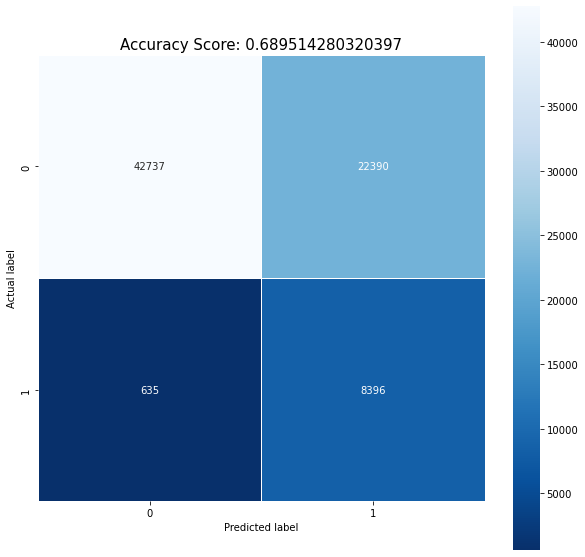

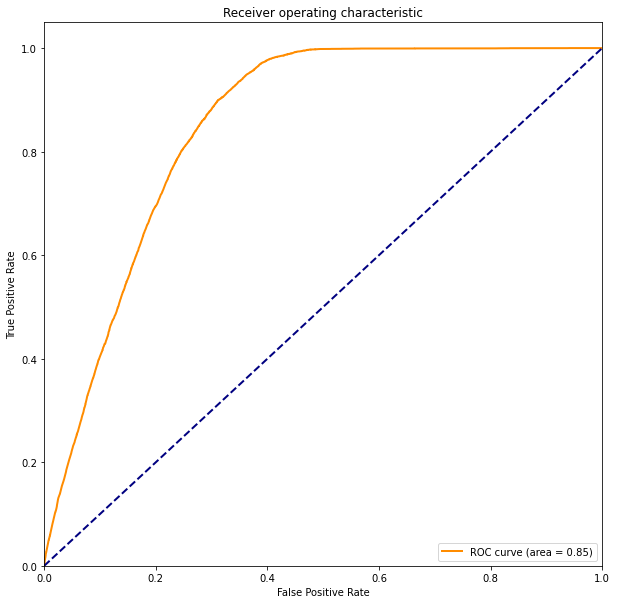

In [30]:
evaluateModel('rf.pkl', X_test, y_test)